In [2]:
import os
import pandas as pd
import numpy as np

In [4]:
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

In [5]:
from sklearn import preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder

## Load data

In [297]:
for file_name in os.listdir("files"):
    if file_name.endswith('.csv'):
        file_path = os.path.join("files", file_name)

        df_name = os.path.splitext(file_name)[0]
        globals()[df_name] = pd.read_csv(file_path)


## SANITY CHECK

In [11]:
#NO MISTAKE IN RETIREES CLASSIFICATION ?

ids_1 = set(learn_dataset_retired_pension["PRIMARY_KEY"])
ids_2 = set(learn_dataset_retired_jobs["PRIMARY_KEY"])
ids_3 = set(learn_dataset_retired_former["PRIMARY_KEY"])

# Step 2: Check the equality of the IDs between datasets
def check_sanity(ids_a, ids_b, dataset_a, dataset_b):
    if ids_a == ids_b:
        print(f"Sanity check passed: {dataset_a} and {dataset_b} contain the same individuals.")
    else:
        print(f"Sanity check failed: There are differences in the individuals from {dataset_a} and {dataset_b}")

check_sanity(ids_1, ids_2, "Dataset 1", "Dataset 2")
check_sanity(ids_1, ids_3, "Dataset 1", "Dataset 3")
check_sanity(ids_2, ids_3, "Dataset 2", "Dataset 3")

not_common_ids_1 = ids_1.symmetric_difference(ids_3)
print(f"Number of people that are not common to dataset 1 and 3: {len(not_common_ids_1)}")

not_common_ids_2 = ids_2.symmetric_difference(ids_3)
print(f"Number of people that are not common to dataset 2 and 3: {len(not_common_ids_2)}")

print("These individuals are in dataset3 but not in dataset1:", ids_3 - ids_1)
print("These individuals are in dataset3 but not in dataset2:", ids_3 - ids_2)

#We are OK, it just that the the dataset 3 has more data. 


Sanity check passed: Dataset 1 and Dataset 2 contain the same individuals.
Sanity check failed: There are differences in the individuals from Dataset 1 and Dataset 3
Sanity check failed: There are differences in the individuals from Dataset 2 and Dataset 3
Number of people that are not common to dataset 1 and 3: 2083
Number of people that are not common to dataset 2 and 3: 2083
These individuals are in dataset3 but not in dataset1: {16389, 40966, 8202, 32783, 32784, 8207, 65556, 40989, 40996, 8231, 24621, 8238, 16438, 90170, 32835, 24656, 41044, 41047, 41051, 82011, 32862, 41054, 41056, 41058, 41065, 41067, 73841, 73842, 41078, 90232, 8318, 24707, 90245, 138, 90253, 16528, 49318, 82092, 8369, 24754, 90293, 16571, 49340, 82111, 195, 204, 210, 65749, 57559, 41178, 98525, 49386, 65772, 57589, 98550, 24833, 262, 263, 82184, 65803, 49421, 82189, 82192, 8467, 82197, 310, 82237, 8511, 33090, 74051, 16713, 57680, 24918, 57695, 8544, 33122, 74085, 358, 16743, 362, 41323, 57709, 90488, 90489, 57

## Simplification of categories

In [299]:
# sports
test_dataset_sport = pd.merge(test_dataset_sport, code_Sports, left_on="Sports", right_on="Code")
test_dataset_sport["Sports_Category"] = test_dataset_sport["Categorie"]
test_sports = test_dataset_sport[["PRIMARY_KEY", "Sports_Category"]]

# departments into regions
def merge_and_extract_region(df, merge_column, region_column_name):
    df = pd.merge(df, departments, left_on=merge_column, right_on="DEP")
    df[region_column_name] = df["REG"]
    df.drop(["Nom du département", "REG", "DEP", merge_column], axis=1, inplace=True)
    return df


test_dataset_job = merge_and_extract_region(
    test_dataset_job, merge_column="JOB_DEP", region_column_name="REG_JOB"
)

test_dataset_retired_jobs = merge_and_extract_region(
    test_dataset_retired_jobs, merge_column="JOB_DEP", region_column_name="REG_JOB"
)

test_dataset_retired_jobs = merge_and_extract_region(
    test_dataset_retired_jobs, merge_column="FORMER_DEP", region_column_name="REG_FORMER"
)

In [301]:
#Economic sector into fewer categories (and numeric instead of object/string)
def sector_mapping(nace_code):
    if nace_code == "AZ":  
        return "Agriculture, forestry and fishing)"
    elif "BZ" <= nace_code <= "EZ":
        return "Manufacturing, mining and quarrying and other industrial activities"
    elif nace_code == "FZ": 
        return "Construction"
    elif "GZ" <= nace_code <= "IZ":  
        return "Wholesale and retail trade, transportation and storage, accommodation and food service activities"
    elif "JA" <= nace_code <= "JC":
        return "Information and communication"
    elif nace_code == "KZ": 
        return "Financial and insurance activities"
    elif nace_code == "LZ": 
        return "Real estate activities"
    elif "MA" <= nace_code <= "NZ":
        return "Professional, scientific, technical, administrative and support service activities"
    elif "OZ" <= nace_code <= "QB":
        return "Public administration and defence, education, human health and social work activities"
    elif "RZ" <= nace_code <= "UZ":
        return "Other services activities"
    else:
        return "Unknown Sector"

code_Economic_sector["Nomenclature"] = code_Economic_sector["Code"].map(sector_mapping)
code_Economic_sector["Economic_sector_num"] = pd.factorize(code_Economic_sector["Nomenclature"])[0] + 1

#code_emp_contract["emp_contract_num"] = pd.factorize(code_emp_contract["Code"])[0] + 1
code_HIGHEST_CREDENTIAL["HIGHEST_CREDENTIAL_num"] = pd.factorize(code_HIGHEST_CREDENTIAL["Code"])[0] + 1
code_act["act_num"] = pd.factorize(code_act["Code"])[0] + 1

#learn_dataset_emp_contract = pd.merge(learn_dataset_emp_contract, code_emp_contract, left_on="emp_contract",  right_on="Code")
#learn_dataset_emp_contract.drop(["Code", "Libellé"], axis=1, inplace=True)
#replace this with one-hot-encoding

## Merging

In [304]:
test_data = test_dataset

test_data = pd.merge(test_data, code_act, left_on="act", right_on="Code", how="left")
test_data.drop(["Code", "Libellé"], axis=1, inplace=True)
test_data = pd.merge(test_data, code_HIGHEST_CREDENTIAL, left_on="HIGHEST_CREDENTIAL", right_on="Code", how="left")
test_data.drop(["Code", "Libellé", "HIGHEST_CREDENTIAL"], axis=1, inplace=True)

In [306]:
test_dfs = [test_dataset_emp_contract, test_dataset_job, test_dataset_retired_former, test_dataset_retired_jobs, test_dataset_retired_pension, test_sports]

for df in test_dfs:
    test_data = pd.merge(test_data, df, on="PRIMARY_KEY", how="outer")

In [308]:
def combine_columns(col_x, col_y):
    return col_x.fillna(col_y) if col_y is not None else col_x

for column in test_data.columns:
    if column.endswith('_x'):
        base_column = column[:-2]  # Remove `_x` suffix
        y_column = base_column + '_y'
        if y_column in test_data.columns:
            # Combine the columns
            test_data[base_column] = combine_columns(test_data[column], test_data[y_column])
            # Drop the original `_x` and `_y` columns
            test_data = test_data.drop(columns=[column, y_column])


## Formatting

In [311]:
def household_num(value):
    parts = value.split('|')  # Split the value by '|'
    if parts[1] in {'1', '2', '3'}:  # For M|1|-- to M|3|--
        return int(parts[1])
    elif parts[1] == '4':  # For M|4|1 to M|4|4
        return 4 + (int(parts[2]) - 1)  # 4 + (1-1), 4 + (2-1), etc.
    return None  # Handle unexpected cases gracefully

code_HOUSEHOLD_TYPE['HOUSEHOLD_TYPE_num'] = code_HOUSEHOLD_TYPE['Code'].apply(household_num)
test_data['HOUSEHOLD_TYPE'] = test_data['HOUSEHOLD_TYPE'].apply(household_num)


In [313]:
test_data["JOB_42_og"] = test_data["JOB_42"]
test_data["FORMER_JOB_42_og"] = test_data["FORMER_JOB_42"]
test_data["JOB_42"] = test_data["JOB_42"].str.extract(r'csp_(\d+)_')[0].astype(int)
test_data["FORMER_JOB_42"] = test_data["FORMER_JOB_42"].str.extract(r'csp_(\d+)_')[0].astype("Int64")
test_data["employee_count"] = test_data["employee_count"].str.extract(r'tr_(\d)')[0].astype("Int64")
test_data["Employer_category"] = test_data["Employer_category"].str.extract(r'ct_(\d)')[0].astype("Int64")

test_data = pd.merge(test_data, code_Economic_sector, left_on="Economic_sector", right_on="Code", how="left")

test_data = pd.merge(test_data, code_work_description_map, left_on="work_description", right_on="N3", how="left")
test_data.drop(["work_description", "N3", "N2"], axis=1, inplace=True)
test_data["N1"] = test_data["N1"].str.extract(r'csp_(\d)')[0].astype("Int64")
test_data.rename(columns={"N1": "work_description"}, inplace=True)

test_data["emp_contract"] = combine_columns(test_data["emp_contract"], test_data["former_emp_contract"])
test_data["Pay"] = combine_columns(test_data["Pay"], test_data["RETIREMENT_PAY"])
#learn_data['is_retired'] = (learn_data['JOB_42'] == 7).astype(int)
#learn_data['is_unemployed'] = (learn_data['act'].str.startswith('TACT2_') & (learn_data['act'] != 'TACT2_1')).astype(int)
#learn_data['is_unemployed'] = (learn_data['act'] == 'TACT1_2').astype(int)

In [314]:
def categorize_retirement_age():
    global test_data  # Modify the global learn_data DataFrame
    
    # Ensure the retirement_age column is numeric
    test_data['retirement_age'] = pd.to_numeric(test_data['retirement_age'], errors='coerce')
    
    # Define the bins and corresponding labels
    bins = [0, 57, 60, 61, 63, 65, float('inf')]  # Specify edges for the ranges
    labels = ['<57', '57-59', '60', '61-62', '63-64', '65+']  # Labels for ranges

    # Initial categorization with pd.cut
    test_data['retirement_age_cat'] = pd.cut(
        test_data['retirement_age'], 
        bins=bins, 
        labels=labels, 
        right=False,  # Left-closed intervals
        include_lowest=True
    )


    # Ensure missing values in retirement_age_cat are handled properly
    test_data['retirement_age_cat'] = test_data['retirement_age_cat'].astype(object)  # Avoid ambiguity with NA
    
    # Handle exact matches for 60 and 65
    test_data.loc[test_data['retirement_age'] == 60, 'retirement_age_cat'] = '60'

# Call the function
categorize_retirement_age()

In [317]:
# types
test_data["sex"] = pd.factorize(test_data["sex"])[0]
test_data["studying"] = test_data["studying"].astype("int64")
#or learn_data["Sports_Category"] = pd.to_numeric(learn_data["Sports_Category"], errors='coerce').astype("Int64")
test_data["Sports_Category"] = test_data["Sports_Category"].fillna(0).astype("int64")
test_data["REG_JOB"] = pd.to_numeric(test_data["REG_JOB"], errors='coerce').astype('Int64')
test_data["REG_FORMER"] = pd.to_numeric(test_data["REG_FORMER"], errors='coerce').astype('Int64')
test_data["retirement_age"] = pd.to_numeric(test_data["retirement_age"], errors='coerce').astype('Int64')
test_data["WORKING_HOURS"] = pd.to_numeric(test_data["WORKING_HOURS"], errors='coerce').astype('Int64')
test_data["Economic_sector_num"] = pd.to_numeric(test_data["Economic_sector_num"], errors='coerce').astype('Int64')
test_data["Pay"] = pd.to_numeric(test_data["Pay"], errors='coerce').astype('Int64')


In [319]:
def replace_na_with_category(column_name):
    global test_data  # Ensures we modify the global learn_data directly

    # Convert the column to categorical
    test_data[column_name] = test_data[column_name].astype('category')
    
    # Define categories to add
    additional_categories = ['Unemployed', 'Retired_Missing', 'Employed_Missing']
    
    # Add the specified categories
    test_data[column_name] = test_data[column_name].cat.add_categories(additional_categories)
    
    test_data.loc[(test_data[column_name].isna()) & (test_data['JOB_42'] == 7), column_name] = 'Retired_Missing'
    test_data.loc[(test_data[column_name].isna()) & (test_data['act_num'] == 1), column_name] = 'Employed_Missing'
    test_data.loc[(test_data[column_name].isna()) & ((test_data['JOB_42'] == 8) | (test_data['act_num'] == 2)), column_name] = 'Unemployed'
    #learn_data[column_name] = learn_data[column_name].fillna("Unemployed")

replace_na_with_category("emp_contract")
replace_na_with_category("TYPE_OF_CONTRACT")
replace_na_with_category("WORK_CONDITION")
replace_na_with_category("labor_force_status")
replace_na_with_category("Economic_sector_num")
replace_na_with_category("REG_JOB")
replace_na_with_category("REG_FORMER")
replace_na_with_category("work_description")
replace_na_with_category("retirement_age_cat")
#do last after imputing
#replace_na_with_category("Employer_category") #need numbers only
#replace_na_with_category("employee_count")

do one-hot-encoding for WORK_CONDITION, TYPE_OF_CONTRACT, labor_force_status
--should we just do one hot encoding for every vategorical var? even sex?

for all now numerical cats but with missing values, can do +1 and make fillna as 0

note: TACT2_3 doesn't exist in dataset - no under 14 year olds

In [322]:
test_data['Employer_category'] = test_data.apply(
    lambda row: 10 if pd.isna(row['Employer_category']) and (row['JOB_42'] == 8 or row['act_num'] == 2) #unemployed
    else (0 if pd.isna(row['Employer_category']) else row['Employer_category']), #employed and retired missing
    axis=1
)
test_data['employee_count'] = test_data.apply(
    lambda row: 7 if pd.isna(row['employee_count']) and (row['JOB_42'] == 8 or row['act_num'] == 2)
    else (0 if pd.isna(row['employee_count']) else row['employee_count']),
    axis=1
)

In [323]:
#learn_data.loc[learn_data['JOB_42'].str.startswith('csp_7', na=False), 'JOB_42'] = learn_data['FORMER_JOB_42']
# Replace values in 'JOB_42' with 'FORMER_JOB_42' where JOB_42 == 7
test_data.loc[test_data['JOB_42'] == 7, 'JOB_42'] = test_data['FORMER_JOB_42']
test_data.loc[(test_data['emp_contract'] == 'Unemployed') & (test_data['Pay'].isna()), 'Pay'] = 0
test_data.loc[(test_data['emp_contract'] == 'Unemployed') & (test_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 0

test_data = test_data.drop(columns=["act", "INSEE_CODE", "former_emp_contract", "RETIREMENT_PAY", "retirement_age", "Economic_sector", "Code", "Libellé", "Nomenclature"])
#or keep nomenclature, remove economic_sector_num
#remove INSEE_CODE?

# Handling Missing Data

In [327]:
test_data.loc[test_data['JOB_42_og'].str.startswith('csp_7', na=False), 'JOB_42_og'] = test_data['FORMER_JOB_42_og']

#agriculture
test_data.loc[(test_data['JOB_42'] == 1) & (test_data['Pay'].isna()), 'Pay'] = 50000 #avg annual pay for farmers
test_data.loc[(test_data['JOB_42'] == 1) & (test_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2860 #avg annual hours for agriculture

#artisans
test_data.loc[(test_data['JOB_42_og'] == 'csp_2_1') & (test_data['Pay'].isna()), 'Pay'] = 24000 #median annual pay for artisans
test_data.loc[(test_data['JOB_42_og'] == 'csp_2_1') & (test_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2288

#commerçant
test_data.loc[(test_data['JOB_42_og'] == 'csp_2_2') & (test_data['Pay'].isna()), 'Pay'] = 39937
test_data.loc[(test_data['JOB_42_og'] == 'csp_2_2') & (test_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2444

#chefs d'enterprise
test_data.loc[(test_data['JOB_42_og'] == 'csp_2_3') & (test_data['Pay'].isna()), 'Pay'] = 58248
test_data.loc[(test_data['JOB_42_og'] == 'csp_2_3') & (test_data['WORKING_HOURS'].isna()), 'WORKING_HOURS'] = 2704

In [335]:
test_data.drop(["JOB_42_og", "FORMER_JOB_42_og", "FORMER_JOB_42"], axis=1, inplace=True)

In [337]:
test = test_data

test["emp_contract"] = pd.factorize(test["emp_contract"])[0]
test["Economic_sector_num"] = pd.factorize(test["Economic_sector_num"])[0]
test["work_description"] = pd.factorize(test["work_description"])[0]
test["retirement_age_cat"] = pd.factorize(test["retirement_age_cat"])[0]
test["REG_JOB"] = pd.factorize(test["REG_JOB"])[0]
test["REG_FORMER"] = pd.factorize(test["REG_FORMER"])[0]
test["labor_force_status"] = pd.factorize(test["labor_force_status"])[0]
test["WORK_CONDITION"] = pd.factorize(test["WORK_CONDITION"])[0]
test["TYPE_OF_CONTRACT"] = pd.factorize(test["TYPE_OF_CONTRACT"])[0]

#learn["employee_count_encoded"] = learn["employee_count_encoded"].astype("int64")
#learn["Employer_category_encoded"] = learn["Employer_category_encoded"].astype("int64")
#learn["Pay"] = learn["Pay"].astype("int64")
#learn["WORKING_HOURS"] = learn["WORKING_HOURS"].astype("int64")

In [331]:
#make all relevant (categorical) cols numerical
#test_data['employee_count_num'] = LabelEncoder().fit_transform(test_data['employee_count'])
#test_data['Employer_category_num'] = LabelEncoder().fit_transform(test_data['Employer_category'])
#test_data['retirement_age_cat_num'] = LabelEncoder().fit_transform(test_data['retirement_age_cat'])
#test_data['REG_JOB_num'] = pd.factorize(test_data['REG_JOB'])[0]
#learn_data['REG_JOB_num'] = LabelEncoder().fit_transform(learn_data['REG_JOB'])
#learn_data['retirement_age_cat_num'] = LabelEncoder().fit_transform(learn_data['retirement_age_cat'])
#learn_data['Employer_category_num']

In [339]:
test_data.dtypes

PRIMARY_KEY               int64
sex                       int64
JOB_42                    int64
studying                  int64
age_2020                  int64
HOUSEHOLD_TYPE            int64
act_num                   int64
HIGHEST_CREDENTIAL_num    int64
emp_contract              int64
Pay                       Int64
REG_FORMER                int64
Sports_Category           int64
Employer_category         int64
employee_count            int64
TYPE_OF_CONTRACT          int64
WORK_CONDITION            int64
labor_force_status        int64
WORKING_HOURS             Int64
REG_JOB                   int64
Economic_sector_num       int64
work_description          int64
retirement_age_cat        int64
dtype: object

In [341]:
test

,PRIMARY_KEY,sex,JOB_42,studying,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,emp_contract,Pay,...,Employer_category,employee_count,TYPE_OF_CONTRACT,WORK_CONDITION,labor_force_status,WORKING_HOURS,REG_JOB,Economic_sector_num,work_description,retirement_age_cat
0,2,0,2,0,83,7,3,4,0,39937,...,0,0,0,0,0,2444,0,0,0,0
1,3,1,2,0,56,4,1,6,1,39937,...,0,0,1,1,1,2444,1,1,1,1
2,4,1,5,0,50,4,1,6,2,21952,...,8,6,2,2,2,1670,2,2,2,1
3,6,0,8,1,15,4,4,3,3,0,...,10,7,3,3,3,0,3,3,3,2
4,9,1,5,0,61,4,1,6,2,19932,...,8,3,2,2,2,1562,2,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50035,100071,1,4,0,55,6,1,11,2,20192,...,8,3,2,4,2,114,5,2,4,1
50036,100074,1,5,0,90,1,3,6,2,15799,...,0,0,2,2,2,430,5,8,2,5
50037,100075,1,5,0,68,5,3,3,2,21121,...,8,1,2,2,2,2943,5,8,2,3
50038,100080,0,4,0,51,4,1,5,2,8803,...,9,1,2,2,2,1050,5,10,4,1


In [343]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(test)) 

There are 2 columns that have missing values.
               Missing Values  % of Total Values
WORKING_HOURS            3723                7.4
Pay                      3300                6.6


In [347]:
test.to_csv("test.csv", index=False)

In [350]:
test.dtypes

PRIMARY_KEY               int64
sex                       int64
JOB_42                    int64
studying                  int64
age_2020                  int64
HOUSEHOLD_TYPE            int64
act_num                   int64
HIGHEST_CREDENTIAL_num    int64
emp_contract              int64
Pay                       Int64
REG_FORMER                int64
Sports_Category           int64
Employer_category         int64
employee_count            int64
TYPE_OF_CONTRACT          int64
WORK_CONDITION            int64
labor_force_status        int64
WORKING_HOURS             Int64
REG_JOB                   int64
Economic_sector_num       int64
work_description          int64
retirement_age_cat        int64
dtype: object

# Prediction start

In [705]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV


In [ ]:
learn_data["sex"] = learn_data["sex"].astype('category')
learn_data["JOB_42"] = learn_data["JOB_42"].astype('category')
learn_data["Sports_Category"] = learn_data["Sports_Category"].astype('category')
learn_data["studying"] = learn_data["studying"].astype('category')
learn_data["act_num"] = learn_data["act_num"].astype('category')
learn_data["HOUSEHOLD_TYPE"] = learn_data["HOUSEHOLD_TYPE"].astype('category')
learn_data["act_num"] = learn_data["act_num"].astype('category')
learn_data["Employer_category_encoded"] = learn_data["Employer_category_encoded"].astype('category')
learn_data["employee_count_encoded"] = learn_data["employee_count_encoded"].astype('category')


In [53]:
learn_data.dtypes

target                     float64
PRIMARY_KEY                  int64
sex                       category
JOB_42                    category
studying                  category
INSEE_CODE                  object
age_2020                     int64
HOUSEHOLD_TYPE            category
act_num                   category
HIGHEST_CREDENTIAL_num       int64
RESIDENTS                    int64
Lat                        float64
long                       float64
emp_contract              category
Pay                        float64
REG_FORMER                category
Sports_Category           category
Employer_category            int64
employee_count               int64
TYPE_OF_CONTRACT          category
WORK_CONDITION            category
labor_force_status        category
WORKING_HOURS              float64
REG_JOB                   category
JOB_42_og                   object
FORMER_JOB_42_og            object
Economic_sector_num       category
work_description          category
retirement_age_cat  

In [713]:
learn_ohe = learn_data
learn_ohe = pd.get_dummies(ML)

# Random Forest

In [93]:
learn = learn_data

In [111]:
learn["emp_contract"] = pd.factorize(learn["emp_contract"])[0]
learn["Economic_sector_num"] = pd.factorize(learn["Economic_sector_num"])[0]
learn["work_description"] = pd.factorize(learn["work_description"])[0]
learn["retirement_age_cat"] = pd.factorize(learn["retirement_age_cat"])[0]
learn["REG_JOB"] = pd.factorize(learn["REG_JOB"])[0]
learn["REG_FORMER"] = pd.factorize(learn["REG_FORMER"])[0]
learn["labor_force_status"] = pd.factorize(learn["labor_force_status"])[0]
learn["WORK_CONDITION"] = pd.factorize(learn["WORK_CONDITION"])[0]
learn["TYPE_OF_CONTRACT"] = pd.factorize(learn["TYPE_OF_CONTRACT"])[0]

learn["employee_count_encoded"] = learn["employee_count_encoded"].astype("int64")
learn["Employer_category_encoded"] = learn["Employer_category_encoded"].astype("int64")
learn["Pay"] = learn["Pay"].astype("int64")
learn["WORKING_HOURS"] = learn["WORKING_HOURS"].astype("int64")

In [113]:
learn.dtypes

target                       float64
PRIMARY_KEY                    int64
sex                            int64
JOB_42                         int64
studying                       int64
age_2020                       int64
HOUSEHOLD_TYPE                 int64
act_num                        int64
HIGHEST_CREDENTIAL_num         int64
emp_contract                   int64
Pay                            int64
REG_FORMER                     int64
Sports_Category                int64
TYPE_OF_CONTRACT               int64
WORK_CONDITION                 int64
labor_force_status             int64
WORKING_HOURS                  int64
REG_JOB                        int64
Economic_sector_num            int64
work_description               int64
retirement_age_cat             int64
Employer_category_encoded      int64
employee_count_encoded         int64
Encoded_emp_contract           int64
dtype: object

## attempt

In [195]:
x_train

,PRIMARY_KEY,sex,JOB_42,studying,age_2020,HOUSEHOLD_TYPE,act_num,HIGHEST_CREDENTIAL_num,emp_contract,Pay,...,WORK_CONDITION,labor_force_status,WORKING_HOURS,REG_JOB,Economic_sector_num,work_description,retirement_age_cat,Employer_category_encoded,employee_count_encoded,Encoded_emp_contract
0,1,0,5,0,34,3,1,10,0,17011,...,0,0,1470,0,0,0,0,9,1,5
1,5,1,6,0,80,7,3,6,0,17598,...,0,0,793,1,1,1,1,9,1,5
2,7,0,3,0,63,4,1,11,1,1241,...,1,1,1241,2,2,2,0,9,4,7
3,8,1,3,0,50,4,1,9,0,57220,...,0,0,1201,3,3,3,0,9,1,5
4,10,0,5,0,68,7,2,6,2,0,...,2,2,0,4,4,4,2,10,7,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50038,100077,0,8,1,29,5,6,6,2,0,...,2,2,0,4,4,4,2,10,7,9
50039,100078,0,4,0,34,4,1,9,0,15890,...,3,0,665,3,5,5,0,8,6,5
50040,100079,0,5,0,29,6,1,8,0,47552,...,0,0,3000,3,5,0,0,8,4,5
50041,100081,1,8,0,57,3,7,6,2,0,...,2,2,0,4,4,4,2,10,7,9


In [190]:
x_train = learn.drop(columns=["target"])
y_train = learn["target"]

In [192]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train,
                                                    y_train, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [194]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

In [ ]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],     # Number of trees in the forest
    'max_depth': [None, 2, 5, 10, 20, 30],    
    'min_samples_split': [2, 5, 10, 15, 25]  
}

# Define cross-validation with 5 folds
cv_folds = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42)

# Set up the GridSearchCV for RandomForestRegressor with appropriate scoring metric
rf_search = GridSearchCV(rf, param_grid_rf, cv=cv_folds, n_jobs=-1, scoring="neg_mean_squared_error")

# Fit the model on the training data
rf_res = rf_search.fit(X_train, Y_train)

# Get the best model after GridSearchCV
best_model_rf = rf_search.best_estimator_

# Output the best model and its score
print(f"Best model: {best_model_rf}")
print(f"Best score: {rf_search.best_score_}")

In [ ]:


cross_val_rmse = cross_val_score(rf, X_train, Y_train, cv=10, scoring='neg_root_mean_squared_error')

In [147]:
cv_folds = KFold(5, shuffle=True, random_state=42)

rf = RandomForestRegressor(random_state=42)

rf_grid = {'min_samples_split': [2, 5, 10, 15, 20, 25]),
           'max_depth': [2, 5, 10, 15, 20]}
rf_cv = GridSearchCV(rf, rf_grid, cv=cv_folds, n_jobs=-1, 
                     scoring='neg_root_mean_squared_error')
rf_cv.fit(X_train, Y_train)

results = rf_cv.cv_results_
params = results['params']

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option

Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 5}


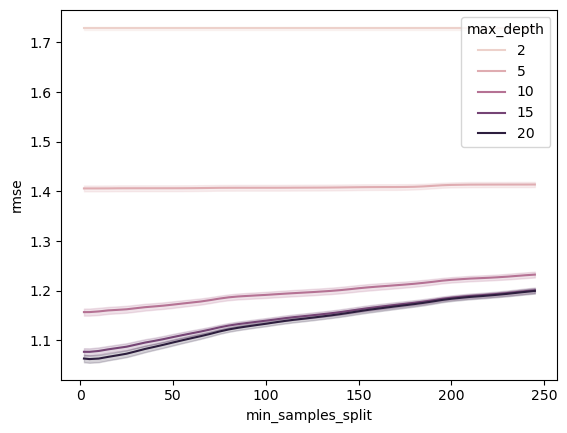

In [168]:
import seaborn as sns

fold_scores = []
for i in range(5):
    fold_scores.append(-results[f'split{i}_test_score'])
    
df = pd.DataFrame(params)
for i, fold_score in enumerate(fold_scores):
    df[f'fold_{i}'] = fold_score

df_melted = df.melt(id_vars=['max_depth', 'min_samples_split'], var_name='fold', value_name='rmse')

sns.lineplot(x='min_samples_split', y='rmse', hue='max_depth', data=df_melted, errorbar='se')

print("Best Hyperparameters:", rf_cv.best_params_)

In [183]:
y_test_pred = rf_cv.predict(X_test)

print("RMSE on the learning set:", root_mean_squared_error(Y_train, rf_cv.predict(X_train)))
print("RMSE on the test set:", root_mean_squared_error(Y_test, rf_cv.predict(X_test)))

RMSE on the learning set: 0.609688950471318
RMSE on the test set: 1.0412504191527154


In [137]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, Y_train)

cross_val_rmse = cross_val_score(rf, X_train, Y_train, cv=5, scoring='neg_root_mean_squared_error')

In [144]:
y_test_pred = rf.predict(X_test)

rmse_test = root_mean_squared_error(Y_test, y_test_pred)

print("RMSE on the learning set:", -cross_val_rmse.mean())
print("RMSE on the test set: ", rmse_test)

RMSE on the learning set: 1.0538144449252926
RMSE on the test set:  1.0435643545440383


In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('True Target Value')
plt.ylabel('Predicted Target Value')
plt.title('Prediction vs True Values on Test Set')
plt.show()

In [ ]:
cv_results = pd.DataFrame(dt_cv.cv_results_)
sns.lineplot(x="param_max_depth", y="mean_test_score", data=cv_results, marker='o', label="Mean Test Score (Negative MSE)")
plt.title("Cross-Validation Results")
plt.xlabel("Max Depth")
plt.ylabel("Mean Test Score (Negative MSE)")
plt.show()